In [58]:
from PIL import Image, ImageDraw
from IPython.display import display

import os
import webcolors

from io import BytesIO

import numpy as np
import requests
from PIL import Image
from sklearn.cluster import KMeans

from Pylette.src.color import Color
from Pylette.src.palette import Palette
from Pylette.src.utils import ColorBox

In [59]:
def k_means_extraction(arr, height, width, palette_size):
    arr = np.reshape(arr, (width * height, -1))
    model = KMeans(n_clusters=palette_size, n_init="auto", init="k-means++")
    labels = model.fit_predict(arr)
    palette = np.array(model.cluster_centers_, dtype=int)
    color_count = np.bincount(labels)
    color_frequency = color_count / float(np.sum(color_count))
    colors = []
    for color, freq in zip(palette, color_frequency):
        # Check if the alpha channel is not 0
        if color[3] != 0:
            colors.append(Color(color, freq))
    return colors


def median_cut_extraction(arr, height, width, palette_size):
    arr = arr.reshape((width * height, -1))
    c = [ColorBox(arr)]
    full_box_size = c[0].size

    while len(c) < palette_size:
        largest_c_idx = np.argmax(c)
        c = c[:largest_c_idx] + c[largest_c_idx].split() + c[largest_c_idx + 1 :]

    colors = [Color(map(int, box.average), box.size / full_box_size) for box in c if np.any(box.average[3] != 0)]

    return colors

def extract_colors(
    image=None,
    image_url: str = None,
    palette_size=5,
    resize=True,
    mode="KM",
    sort_mode=None,
):
    if image is None and image_url is None:
        raise ValueError("No image provided")

    if image is None and image_url is not None:
        response = requests.get(image_url)
        if response.status_code == 200 and "image" in response.headers.get(
            "Content-Type", ""
        ):
            img = Image.open(BytesIO(response.content)).convert("RGBA")
        else:
            raise ValueError("The URL did not point to a valid image.")
    else:
        img = Image.open(image).convert("RGBA")

    if resize:
        img = img.resize((256, 256))
    width, height = img.size
    arr = np.asarray(img)

    if mode == "KM":
        colors = k_means_extraction(arr, height, width, palette_size)
    elif mode == "MC":
        colors = median_cut_extraction(arr, height, width, palette_size)
    else:
        raise NotImplementedError("Extraction mode not implemented")

    if sort_mode == "luminance":
        colors.sort(key=lambda c: c.luminance, reverse=False)
    else:
        colors.sort(reverse=True)

    return Palette(colors)


In [63]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour[:3])
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (119, 172, 152)


In [64]:
def display_color_palette(image_path, square_size=100):
    # Load in clothing image
    clothing_img = Image.open(image_path).convert("RGB")
    clothing_img_resized = clothing_img.resize((square_size, square_size))

    # Extract most common colors for palette values
    palette_size = 10
    palette = extract_colors(image=image_path, palette_size=palette_size, resize=True)
    colors = [color.rgb for color in palette]

    # Calculate the dimensions of the image based on the number of colors
    num_colors = len(colors)
    
    palette_width = square_size * num_colors
    palette_height = square_size
    
    # Create a new image with a white background
    palette_img = Image.new("RGB", (palette_width, palette_height), color="white")
    draw = ImageDraw.Draw(palette_img)
    
    # Draw squares for each color
    color_names = []
    for i, color in enumerate(colors):
        x0 = i * square_size
        y0 = 0
        x1 = x0 + square_size
        y1 = y0 + square_size

        # Get color names
        _, color_name = get_colour_name(color)
        color_names.append(color_name)

        draw.rectangle([x0, y0, x1, y1], fill=tuple(color))
    
    # Concatenate the images horizontally
    combined_img = Image.new("RGB", (square_size * (num_colors + 1), palette_img.height))
    combined_img.paste(clothing_img_resized, (0, 0))
    combined_img.paste(palette_img, (clothing_img_resized.width, 0))
    
    # Display the combined image
    display(combined_img)

    return color_names

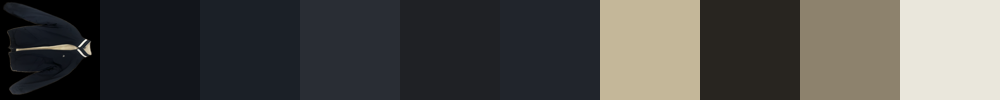

['black', 'black', 'darkslategray', 'black', 'darkslategray', 'tan', 'black', 'gray', 'antiquewhite']


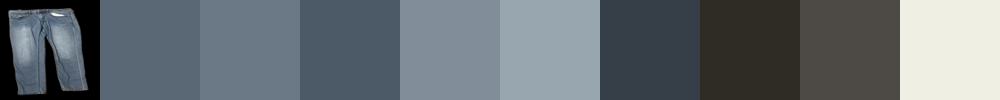

['dimgray', 'slategray', 'dimgray', 'lightslategray', 'darkgray', 'darkslategray', 'darkslategray', 'darkslategray', 'linen']


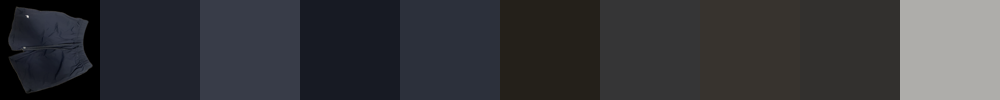

['darkslategray', 'darkslategray', 'black', 'darkslategray', 'black', 'darkslategray', 'darkslategray', 'darkslategray', 'darkgray']


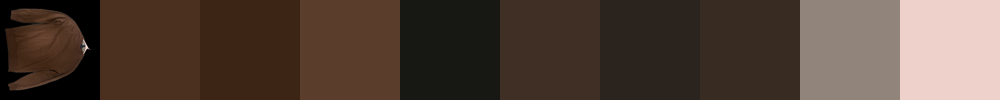

['darkolivegreen', 'darkslategray', 'darkolivegreen', 'black', 'darkslategray', 'black', 'darkslategray', 'gray', 'pink']


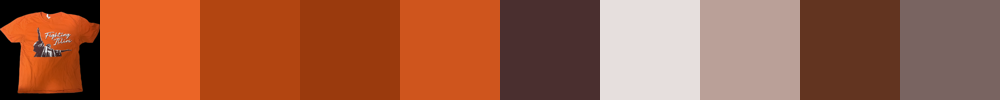

['chocolate', 'sienna', 'saddlebrown', 'chocolate', 'darkslategray', 'gainsboro', 'rosybrown', 'saddlebrown', 'dimgray']


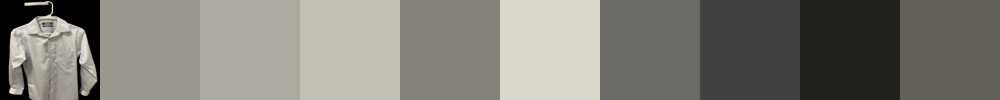

['rosybrown', 'darkgray', 'silver', 'gray', 'lightgray', 'dimgray', 'darkslategray', 'black', 'dimgray']


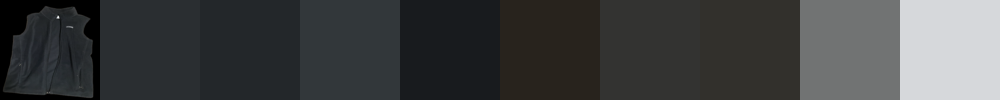

['darkslategray', 'darkslategray', 'darkslategray', 'black', 'black', 'darkslategray', 'darkslategray', 'dimgray', 'gainsboro']


In [65]:
# Loop through all images
input_path = "/Users/josephkuang/Desktop/CS 525/data/no_background_images"
for filename in sorted(os.listdir(input_path)):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)
        colors = display_color_palette(image_path)
        print(colors)
